In [31]:
# Udacity Final Project - Python Data Analysis / Baseball Data
# David Petersen djpetersen@gmail.com 4153363948

1.	Overview

For my final project, I chose the “baseball” dataset. In reading through the documentation, I noticed the dataset contained both information about performance (of players and teams), as well as data on player salaries. I was interested in whether or not how much a team pays in salary influences the rate at which they win games or championships. On first thought, it sees like it should: teams would generally pay for better players, and having better players should result in more wins. There are, however, many things that could disrupt these relationships: player getting injured, teams overpaying players late in their careers after performance has peaked, etc.

In [32]:
# Updates from 1st submission
# - removed float_maker function, using as_type instead as recommended by reviewer
# - all charts and graphs now have english language labels and titles
# - added section (5) on Limitations
# - added section (6) on potential new analysis

In [33]:
# import libraries for analysis & graphing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import matplotlib.ticker as ticker

# Set global option on how float data is displayed
pd.options.display.float_format = '{:,.2f}'.format

2.	Exploratory Data Analysis

I began my analysis by loading the salaries, teams, and team franchises datasets into Python Pandas dataframes, and checking the first 5 rows of each dataset, and data types, to verify the contents. Here is an example from the salary dataset:


In [34]:
# Load a few datasets for exploration
salaries = pd.read_csv('/Users/David/Github/Udacity_Baseball_Analysis/baseballdatabank-master/core/Salaries.csv')
print
print salaries.head() # data check - ok
print
print salaries.dtypes # data check - ok
print

teams = pd.read_csv('/Users/David/Github/Udacity_Baseball_Analysis/baseballdatabank-master/core/Teams.csv')
#print teams.head() # data check - ok
#print
#print teams.dtypes # data check - ok
#print

teamsfranchises = pd.read_csv('/Users/David/Github/Udacity_Baseball_Analysis/baseballdatabank-master/core/TeamsFranchises.csv')
#print teamsfranchises.head() # data check - ok
#print
#print teamsfranchises.dtypes # data check - ok
#print


   yearID teamID lgID   playerID  salary
0    1985    ATL   NL  barkele01  870000
1    1985    ATL   NL  bedrost01  550000
2    1985    ATL   NL  benedbr01  545000
3    1985    ATL   NL   campri01  633333
4    1985    ATL   NL  ceronri01  625000

yearID       int64
teamID      object
lgID        object
playerID    object
salary       int64
dtype: object



Here I noticed that many of the fields imported into Python are integers. I knew that downstream I would want many fields to be floating point, both for formatting purposes as well as for ratios I intend to calculate later.  Below I use the astype function, recommended by my reviewer, to make this change.

To compare salary data and performance data, I first have to understand the character and content of each dataset – what does the data look like? Are there strange or missing values? Is the data consistent over time? 

I began this data exploration with the salaries data. First I calculated the salary paid by each team in each year.  The salary data starts in 1985. There were roughly 30 teams in major league baseball over the 30 year period, giving me almost 900 data observations (888 exactly), and the mean payroll for a team was a little over $57M.

In [35]:
# Exploratory data analysis
# First create datapoints for team salary by year
salaries['salary'] = salaries[['salary']].astype(float)
annual_salary_by_team = salaries.groupby(['yearID','teamID'],as_index = False).sum() # agg by team and year
print annual_salary_by_team.describe()

        yearID         salary
count   888.00         888.00
mean  2,000.47  57,847,972.26
std       8.85  41,479,431.22
min   1,985.00     880,000.00
25%   1,993.00  24,375,500.50
50%   2,001.00  48,798,283.00
75%   2,008.00  81,667,000.00
max   2,015.00 231,978,886.00


That average, however, obscures the fact that the data is not normally distributed – it’s chunky at low values and tails off to the right. A histogram confirms what ‘describe’ also calculated:

Populating the interactive namespace from numpy and matplotlib


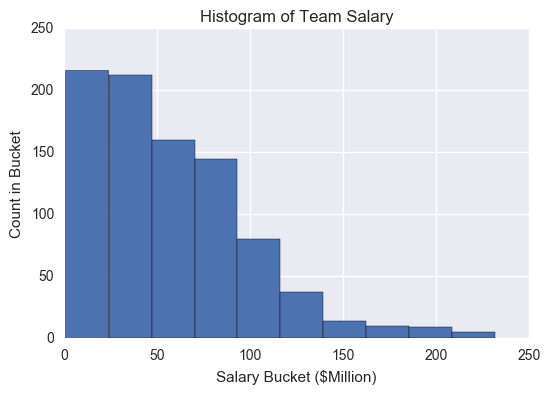

In [36]:
# Histograms of key variables
%pylab inline
histo = annual_salary_by_team[['salary']].hist()
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: ('%.f')%(y*1e-6)))
ax.set_xlabel('Salary Bucket ($Million)')
plt.title('Histogram of Team Salary')
plt.ylabel('Count in Bucket')


I have a suspicion that this is due to the changing nature of salary over time. If salaries are increasing over time, that will result in a relatively small number of salary values at today’s levels, and many lower values associated with distant past years. That’s consistent with what I see in the histogram.

To confirm and consider what to do next, I analyze how salary has changed over time. I used my team-year dataset, and performed another groupby to yield max, min, and mean summary statistics for each year:

Populating the interactive namespace from numpy and matplotlib


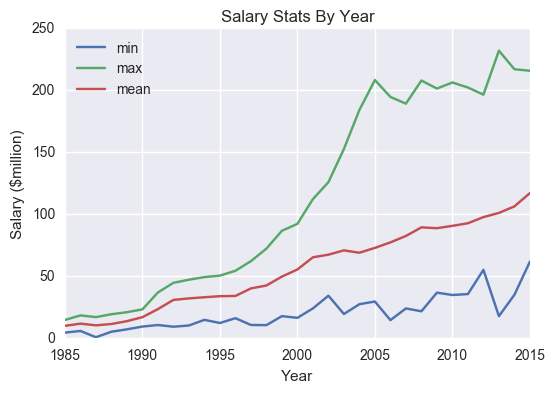

In [37]:
# Examine character of salary data over time
# Create a dataset of average, min, and max salary teams by year for exploration
annual_salary_stats = annual_salary_by_team.groupby('yearID')['salary'].agg(['min','max','mean'])
#print annual_salary_stats # data check = ok
#print annual_salary_by_team[(annual_salary_by_team['yearID'] == 1987)] # data check = ok

# Line plot of results
%pylab inline
ann_sal_plot = annual_salary_stats.plot.line(title='Salary Stats By Year') # plot results
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: ('%.f')%(y*1e-6)))
ax.set_ylabel('Salary ($million)')
plt.xlabel('Year')


This chart confirms my suspicion. The average salary (red line) has consistently drifted upward over time. The minimum salary has, as well, but what is most striking is the maximum salary paid by a team has increased dramatically, especially over the period from 2000 to 2005.

I was curious about this last fact – which team or teams has been driving the maximum salary higher over that period? I used pandas to find the max salary in each year, and then created a true-false dataset showing whether a team-year’s salary was equal to the max for that year. By filtering by this true-false dataset, I created a list of the max team for each year (then merged to get full team name):


In [38]:
# Explore the max team every year - which team drove big increase between 2000 and 2005?

# Create true/false dataset indicating if that team-year was the max
idx = annual_salary_by_team.groupby(['yearID'])['salary'].transform(max) == annual_salary_by_team['salary']
#print idx.head() # data check - ok

# Find the rows of above dataframe that were true: salary == max_salary
max_salary_team = annual_salary_by_team[idx].reset_index()
#print max_salary_team.head() # data check - ok

# Now match to team names from the ID
# create a dataframe of only the desired columns using a groupby
team_names = pd.DataFrame({'count' : teams.groupby(['teamID','name','yearID']).size()}).reset_index()
max_salary_team = pd.merge(max_salary_team, team_names, how='left', on = ['teamID','yearID'])
print max_salary_team[['yearID', 'name', 'salary']]
# Conclusion: it was largely the New York Yankees. 

    yearID                 name         salary
0     1985       Atlanta Braves  14,807,000.00
1     1986     New York Yankees  18,494,253.00
2     1987     New York Yankees  17,099,714.00
3     1988     New York Yankees  19,441,152.00
4     1989  Los Angeles Dodgers  21,071,562.00
5     1990   Kansas City Royals  23,361,084.00
6     1991    Oakland Athletics  36,999,167.00
7     1992    Toronto Blue Jays  44,788,666.00
8     1993    Toronto Blue Jays  47,279,166.00
9     1994       Atlanta Braves  49,383,513.00
10    1995    Toronto Blue Jays  50,590,000.00
11    1996    Baltimore Orioles  54,490,315.00
12    1997     New York Yankees  62,241,545.00
13    1998    Baltimore Orioles  72,355,634.00
14    1999     New York Yankees  86,734,359.00
15    2000     New York Yankees  92,338,260.00
16    2001     New York Yankees 112,287,143.00
17    2002     New York Yankees 125,928,583.00
18    2003     New York Yankees 152,749,814.00
19    2004     New York Yankees 184,193,950.00
20    2005   

The answer, in the years with the big increases, was always the New York Yankees.

My curiousity satisfied, I returned to the question of what to do with my salary data drifting upwards over time. From previous work with statistics and regression analysis, I knew that this drift causes problems for correlation and regression methods. There actually are two different problems – the first is that the statistical methods will be confused by using non-constant dollars to predict winning. It won’t understand that using 50M dollars in 1990 is different from 50M dollars in 2015. The second issue that, even without considering the “Yankees outliers” identified above, the variance in the dataset is increasing over time. A simple scatter plot of salary by year shows this:

(0, 250000000)

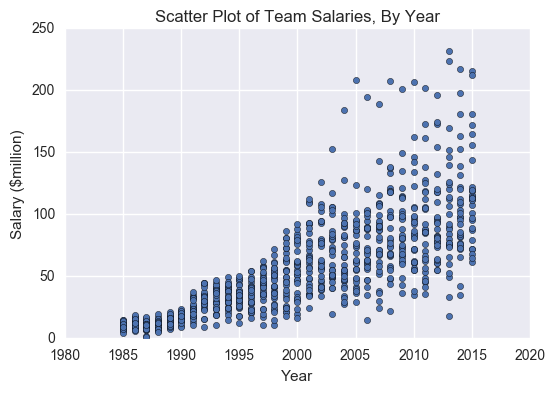

In [39]:
# Simple scatter plot of team salaries, by year
chart = annual_salary_by_team.plot.scatter('yearID', 'salary', title = 'Scatter Plot of Team Salaries, By Year')
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: ('%.f')%(y*1e-6)))
ax.set_ylabel('Salary ($million)')
plt.xlabel('Year')
plt.ylim([0,250000000])


This widening in the distribution on the right of the graph will also cause problems for methods like regression analysis (see “heteroskedasticity: http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html”). I need to compensate for this in my analysis before executing methods like regression.

To combat this, below I normalized the salary data for each year much like what was described in the coursework. For each year, I calculated the mean and standard deviation of salaries, and then calculated each team’s standardized salary as (salary – mean_salary) / std_dev_salary. This gives values that are centered around zero for each year, which most values falling within +/- 3 units of that center. 

In [40]:
# Salary data drifting upward over time, which will cause problems for correlation
# Create a stationary time series of salaries data through normalization 

# first recreate summary stats by team and year, including standard deviation
salary_stats = annual_salary_by_team.groupby('yearID',as_index = False)['salary'].agg(['mean','std','min',]).reset_index()
# merge those stats with team-year salary data
salary_add_stats = pd.merge(annual_salary_by_team, salary_stats, how='left', on = ['yearID'])
# create noramlized metrics for team salary vs. other teams in that year
salary_add_stats['std_salary'] = ((salary_add_stats['salary'] - salary_add_stats['mean']) / salary_add_stats['std'])
#print salary_add_stats.dtypes # data checking - ok
print salary_add_stats.head() # data checking - ok

   yearID teamID        salary          mean          std          min  \
0    1985    ATL 14,807,000.00 10,075,565.23 2,470,845.43 4,613,000.00   
1    1985    BAL 11,560,712.00 10,075,565.23 2,470,845.43 4,613,000.00   
2    1985    BOS 10,897,560.00 10,075,565.23 2,470,845.43 4,613,000.00   
3    1985    CAL 14,427,894.00 10,075,565.23 2,470,845.43 4,613,000.00   
4    1985    CHA  9,846,178.00 10,075,565.23 2,470,845.43 4,613,000.00   

   std_salary  
0        1.91  
1        0.60  
2        0.33  
3        1.76  
4       -0.09  


A plot of these standardized salaries shows something much more tractable for regression and correlation:

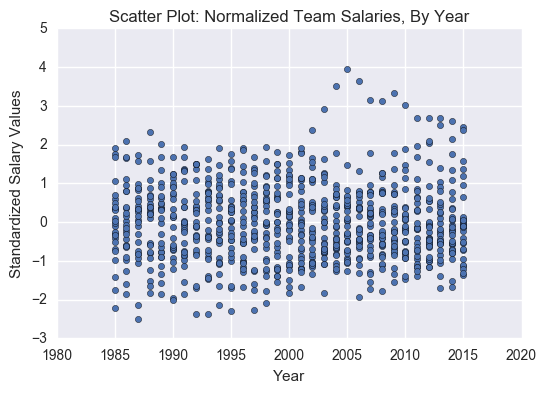

In [41]:
# scatter plot of results
salary_add_stats.plot.scatter('yearID', 'std_salary', title = 'Scatter Plot: Normalized Team Salaries, By Year')
ax = plt.gca()
ax.set_ylabel('Standardized Salary Values')
plt.xlabel('Year')


The Yankees outliers close to 4 standard deviations away from the mean still exist, but most of the data is pretty level over time.

At this point, I believe the salary data is in good enough shape for inferential statistics. I turned my attention to performance data. The original teams dataset shows wins and losses for each team in each year. To  create a single performance metric, I calculated a “win percentage” as the number of wins divided by the sum of wins and losses. A sample of that data is as follows:

In [42]:
# Working with team performance data

# Quick data check - how many teams per year ?
team_counts = teams.groupby(['yearID']).count()
modern_team_counts = team_counts[team_counts.index > 1984]
#print 'Count of teams in dataset, by year: ' + '\n'
#print modern_team_counts.ix[:,'teamID']

# Create a win percentage metric to give single performance measure, control for number of games 
teams['W_float'] = teams[['W']].astype(float)
teams['L_float'] = teams[['L']].astype(float)
teams['win_percent'] = (teams['W_float'] / (teams['W_float'] + teams['L_float']))
performance_stats = teams[['teamID','name','yearID','win_percent']].copy()
#print teams.dtypes # data check - ok
print '\n' + 'Sample of Performance Stats Data: ' + '\n'
print performance_stats.head(10) # data check - ok
#print performance_stats.dtypes # data check - ok


Sample of Performance Stats Data: 

  teamID                     name  yearID  win_percent
0    BS1     Boston Red Stockings    1871         0.67
1    CH1  Chicago White Stockings    1871         0.68
2    CL1   Cleveland Forest Citys    1871         0.34
3    FW1     Fort Wayne Kekiongas    1871         0.37
4    NY2         New York Mutuals    1871         0.48
5    PH1   Philadelphia Athletics    1871         0.75
6    RC1    Rockford Forest Citys    1871         0.16
7    TRO           Troy Haymakers    1871         0.46
8    WS3      Washington Olympics    1871         0.50
9    BL1       Baltimore Canaries    1872         0.65


As with the salary data above, I was interested in the character of the win data over time – was it constant? I calculated the average, min, and max win percentages for each year . . . 

In [43]:
# Analyze distribution of win percentage by year

# Create summary statistics of win percentage by year
win_percent_stats = performance_stats.groupby('yearID', 
    sort = False).agg(['min','max','mean'])
#print win_percent_stats.head() # data check - ok
#print win_percent_stats.dtypes # data check - ok
print win_percent_stats.describe() # data check - ok


      win_percent              
              min    max   mean
count      145.00 145.00 145.00
mean         0.32   0.66   0.50
std          0.07   0.05   0.01
min          0.00   0.59   0.39
25%          0.29   0.63   0.50
50%          0.33   0.65   0.50
75%          0.36   0.68   0.50
max          0.43   0.90   0.50


. . . And plotted them over time. The first chart below shows the results from the beginning of the teams data in 1871 until last year. Interestingly, the win percentage was different in an earlier era of baseball – between 1870 when this data started and 1920. During those years there were teams that consistently higher win percentages than teams today.  There were of course complementary lower win percentage teams, too -- baseball appears to have been less competitive than it is today. To look at just the data where I have salary information, I reran the plot from 1985 to the present (second plot below). The result looks consistent over time, so I am satisfied that the performance data is in good shape, too.

Populating the interactive namespace from numpy and matplotlib


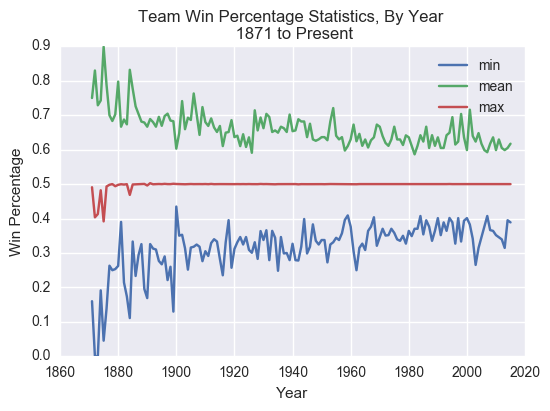

In [44]:
# Create line plot of results, as we did for salary data above
%pylab inline
win_pct_plot = plt.plot(win_percent_stats)
plt.title('Team Win Percentage Statistics, By Year \n 1871 to Present')
plt.xlabel('Year')
plt.ylabel('Win Percentage')
plt.legend(['min','mean','max'])
# Looks stable since salary data started in the mid 80's

Populating the interactive namespace from numpy and matplotlib


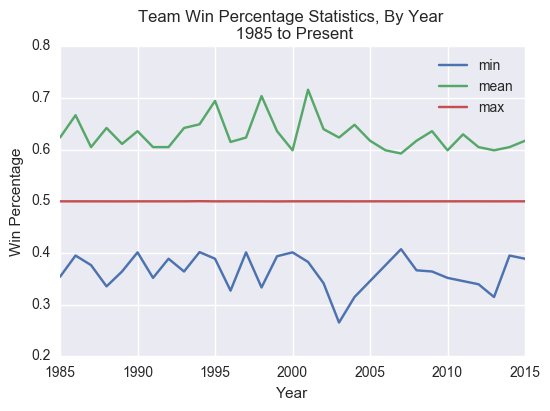

In [45]:
# Create line plot of results, limited to 1985 until present
%pylab inline
win_pct_plot = win_percent_stats[win_percent_stats.index > 1984].plot.line() # plot results
plt.title('Team Win Percentage Statistics, By Year \n 1985 to Present')
plt.xlabel('Year')
plt.ylabel('Win Percentage')
plt.legend(['min','mean','max'])# Looks stable since salary data started in the mid 80's

In order to more deeply understand the performance data, I decided to take a quick look at winning and losing teams. By sorting the dataset of win_percent, and then using head(10) to choose teams, I was able to print out the winningest and losingest teams since the salary data began. Among the winningest teams, I noticed a couple of entries for the New York Yankees (recall, they were often on top in salary), but they didn’t dominate the top 10. The best teams tend to have a win rate of about double the worst teams. A recent entry – the Houston Astros of 2013 – are tied for second losingest team in the era for which we have salary data:

In [46]:
# Look at top 10 and bottom 10 winningest (and losingest) teams since 1985

# Create set of top teams through sorting dataset, print 10
top_teams = performance_stats[performance_stats['yearID'] > \
    1984].sort_values(by='win_percent', ascending=False)
print 'Top 10 Winningest Teams since 1985: ' + '\n' 
print top_teams.head(10)
print '\n'

# Create set of bottom teams through sorting dataset, print 10
bottom_teams = performance_stats[performance_stats['yearID'] > \
    1984].sort_values(by='win_percent', ascending=True)
print 'Top 10 Losing Teams since 1985: ' + '\n' 
print bottom_teams.head(10)
print '\n'

Top 10 Winningest Teams since 1985: 

     teamID                 name  yearID  win_percent
2379    SEA     Seattle Mariners    2001         0.72
2283    NYA     New York Yankees    1998         0.70
2188    CLE    Cleveland Indians    1995         0.69
1959    NYN        New York Mets    1986         0.67
2267    ATL       Atlanta Braves    1998         0.65
2169    MON       Montreal Expos    1994         0.65
2471    SLN  St. Louis Cardinals    2004         0.65
2012    OAK    Oakland Athletics    1988         0.64
2125    ATL       Atlanta Braves    1993         0.64
2403    NYA     New York Yankees    2002         0.64


Top 10 Losing Teams since 1985: 

     teamID                  name  yearID  win_percent
2425    DET        Detroit Tigers    2003         0.27
2725    HOU        Houston Astros    2013         0.31
2446    ARI  Arizona Diamondbacks    2004         0.31
2218    DET        Detroit Tigers    1996         0.33
2276    FLO       Florida Marlins    1998         0.33
19

(3) Comparing Salary and Performance Data

To compare the two datasets, I first merged them together and created a variable called “yankees” which I’ll use for plotting later. Then I ran a bunch of plots and statistical techniques to answer my original question: what impact does salary have on a team’s performance?

In [47]:
# Merge salary and performance data for analysis and regression
#print salary_add_stats.dtypes # checking field types and key names
#print performance_stats.dtypes # checking field types and key names

salary_and_performance = pd.merge(salary_add_stats, performance_stats, 
    how='left', on = ['teamID','yearID'])

# drop unused columns
salary_and_performance = salary_and_performance[['name', 'yearID', 'teamID',
    'salary', 'std_salary', 'win_percent']]
# create a column indicating if the team is the New York Yankees
salary_and_performance['yankees'] = np.where(salary_and_performance['name'] == 'New York Yankees','Y','N')
print salary_and_performance.head() # data checking - ok

                name  yearID teamID        salary  std_salary  win_percent  \
0     Atlanta Braves    1985    ATL 14,807,000.00        1.91         0.41   
1  Baltimore Orioles    1985    BAL 11,560,712.00        0.60         0.52   
2     Boston Red Sox    1985    BOS 10,897,560.00        0.33         0.50   
3  California Angels    1985    CAL 14,427,894.00        1.76         0.56   
4  Chicago White Sox    1985    CHA  9,846,178.00       -0.09         0.52   

  yankees  
0       N  
1       N  
2       N  
3       N  
4       N  


I now have the joint salary-performance dataset, with the key variables bring salary, standardized salary, and win percentage. Simple histograms of each variable show that the standardized salary and win percentage data look approximately normally distributed, a key input to regression analysis:

Populating the interactive namespace from numpy and matplotlib


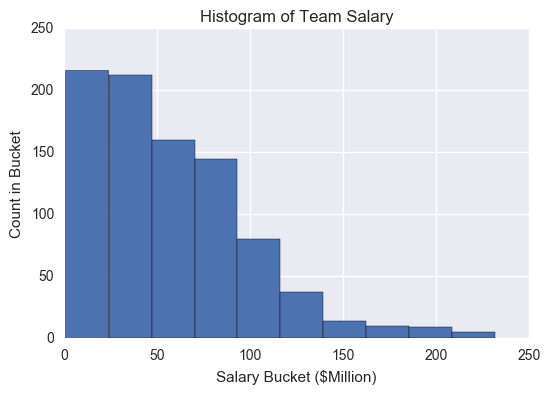

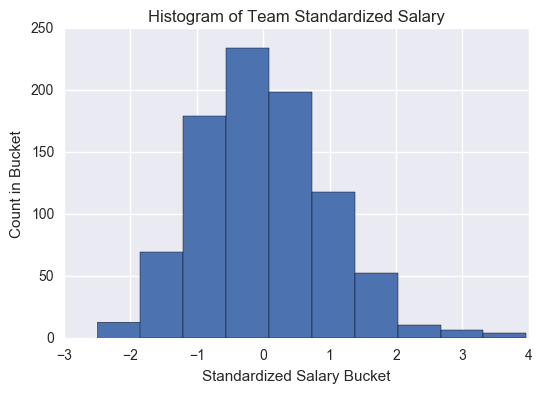

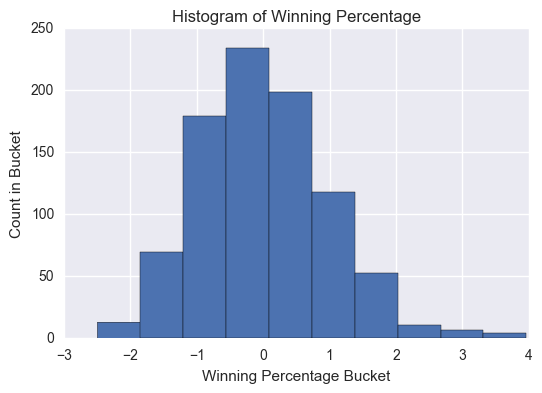

In [48]:
# Histograms of key variables
# Note: I googled like crazy to figure out how to retitle and label these, but was not able to do so
%pylab inline
sal_lim =  salary_and_performance[['win_percent', 'salary', 'std_salary']]

# Salary histogram
sal_histo = salary_and_performance[['salary']].hist()
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: ('%.f')%(y*1e-6)))
ax.set_xlabel('Salary Bucket ($Million)')
plt.title('Histogram of Team Salary')
plt.ylabel('Count in Bucket')

# Standardized Salary histogram
std_histo = salary_and_performance[['std_salary']].hist()
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.set_xlabel('Standardized Salary Bucket')
plt.title('Histogram of Team Standardized Salary')
plt.ylabel('Count in Bucket')

# Winning percentage histogram
win_histo = salary_and_performance[['std_salary']].hist()
ax = plt.gca()
ax.set_xlabel('Winning Percentage Bucket')
plt.title('Histogram of Winning Percentage')
plt.ylabel('Count in Bucket')

Now for direct comparisons. The first plot below shows the raw salary data (unstandardized) against win percentage. This plot gives additional evidence about why using unstandardized data would be a bad idea. The x-axis here is salary, from 0 dollars up to about 250M dollars. There are lots of teams with high win percentages and payrolls of less than 50M dollars – but they were probably all from 20 years ago when payrolls were lower! Estimating a regression through this set of data might yield an upward sloping line, but one with no confidence in the relationship.

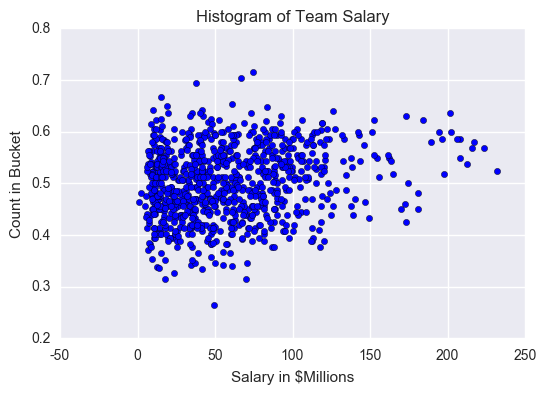

In [49]:
# Scatter plot of raw salary vs. win_percent

raw_sal_perf_scatter = plt.scatter(salary_and_performance.salary, 
    salary_and_performance.win_percent)
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: ('%.f')%(y*1e-6)))
plt.title('Teams Raw Salary Data vs. Win Percentage')
plt.xlabel('Salary in $Millions')
plt.ylabel('Win Percentage')
plt.title('Histogram of Team Salary')
plt.ylabel('Count in Bucket')



print raw_sal_perf_scatter

Now here's the plot of the standardized salary data against win percentage. It looks more like a cloud sloping upward to the right. My first impression is that the relationship is not as tight as I might have expected. Even at salary levels well below the mean (e.g., 1 standard deviation), there are plenty of teams with win rates in the 40 percent range as well as many in the mid 50s or higher in win percentage!

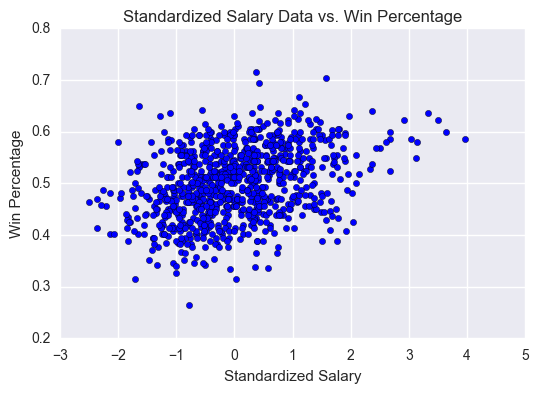

In [50]:
# Scatter plot of standardized salary vs. win_percent

sal_perf_scatter = plt.scatter(salary_and_performance.std_salary, 
    salary_and_performance.win_percent)
plt.title('Standardized Salary Data vs. Win Percentage')
plt.xlabel('Standardized Salary')
plt.ylabel('Win Percentage')

The data points on the right side of the graph -- at very high salaries -- are a bit thin. We don't have a lot of evidence here. Above 2 standardized salary units, the win percentages are pretty much all above 50%, which is consistent with our hypothesis that salary should contribute to winning, but the win percentages are not uniformly among the highest (60%+). 

Based on the analysis of "max salary" above, I wanted to view the New York Yankees' impact on this graph. They are identified by a different color on the scatterplot below:

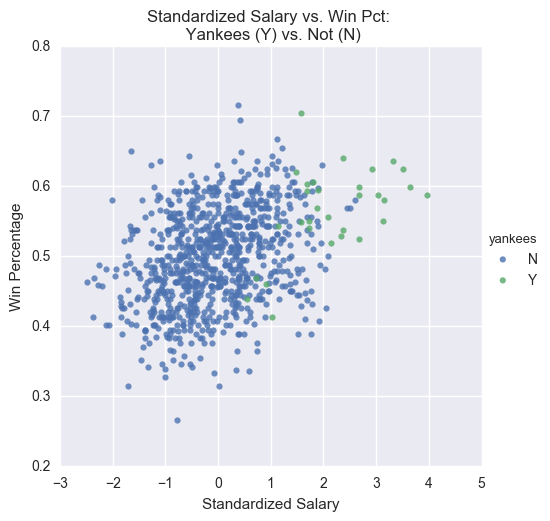

In [51]:
# Show the yankees data points in a different color, highlighting their impact

sns.lmplot('std_salary', 'win_percent', data=salary_and_performance, 
    hue='yankees', fit_reg = False)
plt.title('Standardized Salary vs. Win Pct: \n Yankees (Y) vs. Not (N)')
plt.xlabel('Standardized Salary')
plt.ylabel('Win Percentage')

The Yankees certainly make up a disproportionate percentage of teams with high salaries. And they do seem to have a higher winning percentage when they spend a lot of money.

I also wanted to quantify the relationship between standardized salary and win percentage. I started with correlation, which shows a 0.36 correlation coefficient on a [-1,1] scale. This indicates a positive, though not overwhelmingly strong correlation. 

In [52]:
corr_data = salary_and_performance[['std_salary','win_percent']].corr()
print 'Correlation Coefficients:' + '\n'
print corr_data

Correlation Coefficients:

             std_salary  win_percent
std_salary         1.00         0.36
win_percent        0.36         1.00


As a next step in quantifying the relationship, I ran an ordinary least squares regression analysis of std salary against win percentage. The resulting model below is statistically sigificant (measured by the F-statistic), and says that using the standardized salary data you can explain about 13% of the variation in win percentage. The model is saying that salary is a meaningful contributor to win percentage, but there are lots of other things causing variation, too. On average, an increase of 1 unit in standardized salary yields a 2.5 percentage point increase in win percentage, all else equal.

In [53]:
# Simple ordinary least squares regression analysis
reg_result = sm.ols(formula='win_percent ~ std_salary',
    data = salary_and_performance).fit()

print reg_result.params
print reg_result.summary()

Intercept    0.50
std_salary   0.03
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            win_percent   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     131.4
Date:                Wed, 30 Nov 2016   Prob (F-statistic):           1.81e-28
Time:                        16:41:55   Log-Likelihood:                 1178.4
No. Observations:                 888   AIC:                            -2353.
Df Residuals:                     886   BIC:                            -2343.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
I

Another question that occurred to me during this analysis is whether or not salary levels were able to predict world series wins. The world series championship is the ultimate goal of each baseball season. Any team needs a sufficient winning percentage to get into the playoffs, and then must win a number of individual series from there.

To answer this question, a created a new 0/1 variable for each team-year indicating if they had won the world series. I used the built in get_dummies function. As a check, I used the crosstab function which confirmed that get_dummies had produced 30 world series winners, one for each year in my dataset:

In [54]:
# Analyse the impact of salary on the ability to win the world series

# Start by creating dataset of world series wins vs. standardized salary
teams_ws_wins = teams[['yearID', 'teamID','WSWin']]
#print teams_ws_wins.dtypes # data check - ok
#print salary_and_performance.dtypes
salary_and_wswins = pd.merge(salary_and_performance, teams_ws_wins, 
    how='left', on = ['teamID','yearID'])
#print salary_and_wswins.dtypes # data check - ok

# Create a binary variable on world series wins
binary = pd.get_dummies(salary_and_wswins, 
    columns=['WSWin'])

# How many world series winners from 1986 to 2015?
print pd.crosstab(index = binary['WSWin_Y'], columns='count')

col_0    count
WSWin_Y       
0.00       858
1.00        30


To do exploratory data analysis on a categorical variable, I used boxplots. These show the distribution of standardized salary levels for teams that won the world series, and those that didn't. In the plots below, you can see that the average salary (red line) is clearly higher for winners. But there is a lot of overlap between the two distributions. Based on these facts, salary is likely a contributor to winning the world series, but not overwhelmingly so:

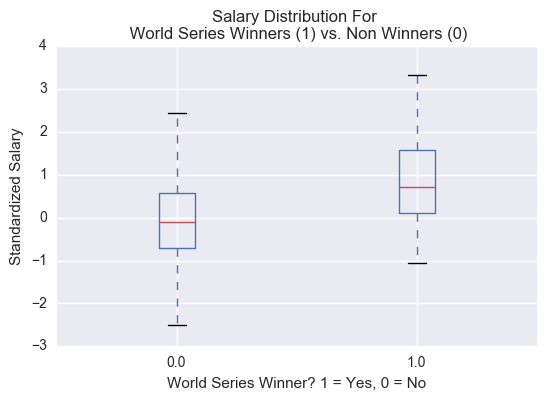

In [55]:
# Create boxplots showing team salary distribution by world series wins
box_data = binary[['std_salary', 'WSWin_Y']]
bp = box_data.boxplot(by='WSWin_Y')
ax = plt.gca()
plt.title('Salary Distribution For \n World Series Winners (1) vs. Non Winners (0)')
plt.suptitle("")
ax.set_ylabel('Standardized Salary')
ax.set_xlabel('World Series Winner? 1 = Yes, 0 = No')


To quantify the relationship between standardized salary and world series wins, I ran a logistic regression, which is the appropriate model for a situation where the dependent variable is binary. The model yields a positive coefficient for standardized salary, but interestingly, the coefficient is not statistically significant at the 95% confidence level. It might be at the 90% confidence level, but here it is not. Contrast that with the winning percentage OLS regression above, where the coefficient was statistically significant. To me, this says that the case for salary as a determinant of world series championships is perhaps weaker than it is for winning percentage.

In [56]:
# Logistic regression of WS Win on Standardized Salary
logit = sm.Logit(binary['WSWin_Y'], binary['std_salary'])
log_result = logit.fit()
print log_result.summary()

Optimization terminated successfully.
         Current function value: 0.691651
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                WSWin_Y   No. Observations:                  888
Model:                          Logit   Df Residuals:                      887
Method:                           MLE   Df Model:                            0
Date:                Wed, 30 Nov 2016   Pseudo R-squ.:                  -3.684
Time:                        16:42:11   Log-Likelihood:                -614.19
converged:                       True   LL-Null:                       -131.12
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
std_salary     0.1117      0.069      1.626      0.104        -0.023     0.246


(4) Conclusion

At the beginning of this project, I set out to understand the relationship between salary compensation and performance in baseball, ultimately using winning percentage and world series wins as measures of performance. Using python pandas and inferential statistics, I discovered that there is in fact a significant relationship between a standardized salary metric and winning percentage, though not one as strong as I had hypothesized. There is a nominally positive relationship also between salary paid and world series wins, although it is not sigificant at the 95% level.

My advice for general managers in baseball, based on this data, is that to have a shot at the world series you want to have a salary that is above the average compared to other teams in the league (see the box plot above). After that, it's hard to say what improves your odds as having an even higher salary level doesn't necessarily do so. Further research might look at key injuries in a season, the relationship between player performance and salary, or other factors.

(5) Potential Limitations

There are definitely limitations to this analysis which prevent it from *proving* that salary drives winning. First, as mentioned above, the inferential statistics methods I used do indicate 'statistical significance' at a 95% level. But at a higher level of confidence, we might fail to reject the null hypothesis that the coefficient for salary in this specification is actually zero. That is even clearer in the second exercise where I looked at salary as a driver of world series wins. In that case, we could not reject the null hypothesis. 

As my first reviewer also pointed out, there is also the limitation in statistics that "correlation does not imply causation." It is possible that instead of salary driving performance, the causal link could run the other direction: teams that start winning have to pay players more to keep them. You could imagine a team of young players that becomes successful, and as a result payroll becomes very expensive. We did not look within the dataset to see if this was true, and there may be data limitations which prevent us from doing so.


(6) Potential Further Analyses

To better understand some of the issues in the limitations section above, there are other analyses we could run. For example, I could look at on-the-field performance metrics of pitching, batting, and fielding to (a) understand if there is a tighter statistical link between these metrics and winning (than salary) and (b) try to determine which of them is most effective to achieve world series wins. I was also interested in the idea of veteran player performance and veteran managerial performance -- does having experience in the league tend to contribute to more wins and world series? These questions could be answered through additional metric definition and regression analyses.